In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import openmc

import os
import numpy as np

In [4]:
#Initial starting source, uniform in fuel only
bounds = [-0.4, -0.4, -0.4, 0.4, 0.4, 0.4]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)

In [22]:
settings = openmc.Settings()
settings.source = openmc.source.Source(space=uniform_dist)
settings.batches = 100
settings.inactive = 25  # keep this at a min of 25, this is the number of power iterations performed, more is always better
settings.particles = 100000  # increase this number to make your results more accurate
settings.temperature = {'tolerance':10000,'multipole':True}
#settings.temperature = {'method':'interpolation','multipole':True}

def buildRange(lower, upper, steps):
    out=[]
    stepSize=(upper-lower)/(steps)
    buffer=lower
    while buffer<=upper:
        out.append(buffer)
        buffer+=stepSize
    return out

In [27]:
settings.export_to_xml()

In [30]:

def getU():
    #got to watch out for those Uranium diggers
    #nukeLife
    uo2 = openmc.Material(1,"fuel",temperature=temp1)
    uo2.add_element('U', 1.0, enrichment=4.0)
    uo2.add_element('O', 2.0)
    uo2.set_density('g/cc', 10.0)
    return uo2
def getZirc():
    zirconium = openmc.Material(2, "zirconium", temperature=temp2)
    zirconium.add_element('Zr', 1.0)
    zirconium.set_density('g/cm3', 6.6)
    return zirconium

def getMod(mod, boron,T):
    if(mod=="H2O"):
            #this function creates borated light water, for other moderators you will need to replace
        mod = openmc.model.borated_water(boron_ppm=boron, temperature=T,pressure=15)
    elif(mod=="D2O"):
        pass
    elif(mod=="GRPHT"):
        pass
    return mod




In [23]:
pitch = buildRange(1,2.5,10)
boron = [0]
nt = len(pitch)
nb = len(boron)
temp1 = 900  #fuel temp
temp2 = 600  #mod temp
modSetting="H2O"
k = np.zeros([nt,nb])
for m in range(nb):
    for j in range(nt):
        #load then materials!!!!!!!!
        uo2=getU()
        zirconium=getZirc() #isn't this so much prettier?
        mod=getMod(modSetting,boron[m],temp2) #loads the moderator
        
        mats = openmc.Materials([uo2, zirconium, mod])
        mats.export_to_xml()
        
        ####################build the surfaces################################
        fuel_or = openmc.ZCylinder(R=0.39)
        clad_ir = openmc.ZCylinder(R=0.40)
        clad_or = openmc.ZCylinder(R=0.46)
        box = openmc.get_rectangular_prism(width=pitch[j], height=pitch[j],
                                   boundary_type='reflective')
        
        #################Build the Cells #######################################
        fuel_region = -fuel_or   #beautiful abuse of operator overloading
        gap_region = +fuel_or & -clad_ir
        clad_region = +clad_ir & -clad_or
        mod_region = box & +clad_or
        # c
        # c Fuel 
        # c
        # c throwback to MCNP
        fuel = openmc.Cell(1, 'fuel')
        fuel.fill = uo2
        fuel.region = fuel_region
        #
        # Gap
        #
        gap = openmc.Cell(2, 'air gap')
        gap.region = gap_region
        #
        # clad 
        #
        clad = openmc.Cell(3, 'clad')
        clad.fill = zirconium
        clad.region = clad_region
        #
        # Moderator 
        #
        moderator = openmc.Cell(4, 'moderator')
        moderator.fill = mod
        moderator.region = mod_region
        
        #I am groot!
        groot = openmc.Universe(cells=(fuel, gap, clad, moderator))
        geom = openmc.Geometry(groot)
        geom.export_to_xml()
        cell_filter = openmc.CellFilter([fuel,gap, clad, moderator])
        #tallies over 2 energy groups with 4 eV being thermal bound
        energy_filter = openmc.EnergyFilter([0., 4.0, 20.0e6])
        t = openmc.Tally(1)
        t.filters = [cell_filter, energy_filter]
        # these are the main reaction rates you should need
        t.scores = ['absorption','nu-fission','fission']
        tallies = openmc.Tallies([t])
        tallies.export_to_xml()
        openmc.run()
        #make sure the number in this file name matches the number of cycles you are running!!!
        sp = openmc.StatePoint('statepoint.100.h5')
        # this reads the tally with all reaction rates, not just absorption
        tally = sp.get_tally(scores=['absorption'])
        # this is the final k-effective of the simulation
        k[j,m] = sp.k_combined[0]
        os.remove('statepoint.100.h5')
        os.remove('summary.h5')
        del sp

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)


[1, 1.15, 1.2999999999999998, 1.4499999999999997, 1.5999999999999996, 1.7499999999999996, 1.8999999999999995, 2.0499999999999994, 2.1999999999999993, 2.349999999999999, 2.499999999999999]

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4909E+00 seconds
   Reading cross sections          =  1.4488E+00 seconds
 Total time in simulation          =  8.7175E+00 seconds
   Time in transport only          =  7.3790E+00 seconds
   Time in inactive batches        =  1.7026E+00 seconds
   Time in active batches          =  7.0150E+00 seconds
   Time synchronizing fission bank =  5.9942E-03 seconds
     Sampling source sites         =  4.1741E-03 seconds
     SEND/RECV source sites        =  1.1115E-03 seconds
   Time accumulating tallies       =  6.5227E-04 seconds
 Total time for finalization       =  5.7206E-03 seconds
 Total time elapsed                =  1.0229E+01 seconds
 Calculation Rate (inactive)       =  14683.6 neutrons/second
 Calculation Rate (active)         =  10691.4 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.5118E+00 seconds
   Reading cross sections          =  1.4701E+00 seconds
 Total time in simulation          =  6.9720E+00 seconds
   Time in transport only          =  5.5605E+00 seconds
   Time in inactive batches        =  1.4118E+00 seconds
   Time in active batches          =  5.5602E+00 seconds
   Time synchronizing fission bank =  5.9055E-03 seconds
     Sampling source sites         =  4.1220E-03 seconds
     SEND/RECV source sites        =  1.0968E-03 seconds
   Time accumulating tallies       =  6.4196E-04 seconds
 Total time for finalization       =  5.7326E-03 seconds
 Total time elapsed                =  8.5045E+00 seconds
 Calculation Rate (inactive)       =  17708.0 neutrons/second
 Calculation Rate (active)         =  13488.7 neutrons/second

 ============================>     RESULTS     <============================

 k-effective (Collision)     =  1.3

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4581E+00 seconds
   Reading cross sections          =  1.4200E+00 seconds
 Total time in simulation          =  6.1100E+00 seconds
   Time in transport only          =  4.8298E+00 seconds
   Time in inactive batches        =  1.2020E+00 seconds
   Time in active batches          =  4.9080E+00 seconds
   Time synchronizing fission bank =  5.7650E-03 seconds
     Sampling source sites         =  3.8952E-03 seconds
     SEND/RECV source sites        =  1.1390E-03 seconds
   Time accumulating tallies       =  6.3437E-04 seconds
 Total time for finalization       =  5.8277E-03 seconds
 Total time elapsed                =  7.5889E+00 seconds
 Calculation Rate (inactive)       =  20798.4 neutrons/second
 Calculation Rate (active)         =  15281.2 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4597E+00 seconds
   Reading cross sections          =  1.4184E+00 seconds
 Total time in simulation          =  5.7125E+00 seconds
   Time in transport only          =  4.3611E+00 seconds
   Time in inactive batches        =  1.1567E+00 seconds
   Time in active batches          =  4.5557E+00 seconds
   Time synchronizing fission bank =  6.1516E-03 seconds
     Sampling source sites         =  4.3168E-03 seconds
     SEND/RECV source sites        =  1.1315E-03 seconds
   Time accumulating tallies       =  6.7333E-04 seconds
 Total time for finalization       =  2.9633E-03 seconds
 Total time elapsed                =  7.1925E+00 seconds
 Calculation Rate (inactive)       =  21613.0 neutrons/second
 Calculation Rate (active)         =  16462.7 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.5009E+00 seconds
   Reading cross sections          =  1.4587E+00 seconds
 Total time in simulation          =  5.4289E+00 seconds
   Time in transport only          =  4.0958E+00 seconds
   Time in inactive batches        =  1.1114E+00 seconds
   Time in active batches          =  4.3175E+00 seconds
   Time synchronizing fission bank =  6.0669E-03 seconds
     Sampling source sites         =  4.2543E-03 seconds
     SEND/RECV source sites        =  1.1180E-03 seconds
   Time accumulating tallies       =  6.1478E-04 seconds
 Total time for finalization       =  3.2016E-03 seconds
 Total time elapsed                =  6.9480E+00 seconds
 Calculation Rate (inactive)       =  22493.7 neutrons/second
 Calculation Rate (active)         =  17371.4 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4398E+00 seconds
   Reading cross sections          =  1.3996E+00 seconds
 Total time in simulation          =  5.3016E+00 seconds
   Time in transport only          =  3.9569E+00 seconds
   Time in inactive batches        =  1.0680E+00 seconds
   Time in active batches          =  4.2336E+00 seconds
   Time synchronizing fission bank =  6.0519E-03 seconds
     Sampling source sites         =  4.2766E-03 seconds
     SEND/RECV source sites        =  1.0805E-03 seconds
   Time accumulating tallies       =  6.3853E-04 seconds
 Total time for finalization       =  3.1564E-03 seconds
 Total time elapsed                =  6.7594E+00 seconds
 Calculation Rate (inactive)       =  23409.2 neutrons/second
 Calculation Rate (active)         =  17715.4 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4259E+00 seconds
   Reading cross sections          =  1.3833E+00 seconds
 Total time in simulation          =  5.3586E+00 seconds
   Time in transport only          =  3.9510E+00 seconds
   Time in inactive batches        =  1.1487E+00 seconds
   Time in active batches          =  4.2100E+00 seconds
   Time synchronizing fission bank =  6.0610E-03 seconds
     Sampling source sites         =  4.2768E-03 seconds
     SEND/RECV source sites        =  1.1036E-03 seconds
   Time accumulating tallies       =  6.3952E-04 seconds
 Total time for finalization       =  5.7649E-03 seconds
 Total time elapsed                =  6.8053E+00 seconds
 Calculation Rate (inactive)       =  21764.2 neutrons/second
 Calculation Rate (active)         =  17814.8 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4921E+00 seconds
   Reading cross sections          =  1.4508E+00 seconds
 Total time in simulation          =  5.3129E+00 seconds
   Time in transport only          =  3.9005E+00 seconds
   Time in inactive batches        =  1.1304E+00 seconds
   Time in active batches          =  4.1825E+00 seconds
   Time synchronizing fission bank =  5.8104E-03 seconds
     Sampling source sites         =  4.0250E-03 seconds
     SEND/RECV source sites        =  1.1059E-03 seconds
   Time accumulating tallies       =  6.1762E-04 seconds
 Total time for finalization       =  3.3005E-03 seconds
 Total time elapsed                =  6.8256E+00 seconds
 Calculation Rate (inactive)       =  22115.2 neutrons/second
 Calculation Rate (active)         =  17932.1 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4988E+00 seconds
   Reading cross sections          =  1.4570E+00 seconds
 Total time in simulation          =  5.0999E+00 seconds
   Time in transport only          =  3.8080E+00 seconds
   Time in inactive batches        =  1.0423E+00 seconds
   Time in active batches          =  4.0576E+00 seconds
   Time synchronizing fission bank =  6.1332E-03 seconds
     Sampling source sites         =  4.3372E-03 seconds
     SEND/RECV source sites        =  1.0945E-03 seconds
   Time accumulating tallies       =  6.1846E-04 seconds
 Total time for finalization       =  5.6996E-03 seconds
 Total time elapsed                =  6.6193E+00 seconds
 Calculation Rate (inactive)       =  23984.4 neutrons/second
 Calculation Rate (active)         =  18483.9 neutrons/second

 ============================>     RESULTS     <=====================

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     =  1.4239E+00 seconds
   Reading cross sections          =  1.3861E+00 seconds
 Total time in simulation          =  5.3268E+00 seconds
   Time in transport only          =  4.0134E+00 seconds
   Time in inactive batches        =  1.0734E+00 seconds
   Time in active batches          =  4.2534E+00 seconds
   Time synchronizing fission bank =  5.7049E-03 seconds
     Sampling source sites         =  3.8916E-03 seconds
     SEND/RECV source sites        =  1.1379E-03 seconds
   Time accumulating tallies       =  6.4395E-04 seconds
 Total time for finalization       =  2.2205E-03 seconds
 Total time elapsed                =  6.7678E+00 seconds
 Calculation Rate (inactive)       =  23290.1 neutrons/second
 Calculation Rate (active)         =  17633.1 neutrons/second

 ============================>     RESULTS     <============================

 k-effective (Collision)     =  1.3

/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/opt/openmc/gnu-dev/openmc/mixin.py:71: IDWarning: Another Tally instance already exists with id=1.
  warn(msg, IDWarning)


In [24]:
print(k)

[[ 1.13834801]
 [ 1.31045955]
 [ 1.40209689]
 [ 1.44388706]
 [ 1.46132378]
 [ 1.46312073]
 [ 1.44334791]
 [ 1.41949839]
 [ 1.38949135]
 [ 1.3564454 ]
 [ 1.31885565]]


(array([ 1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ]),
 <a list of 9 Text yticklabel objects>)

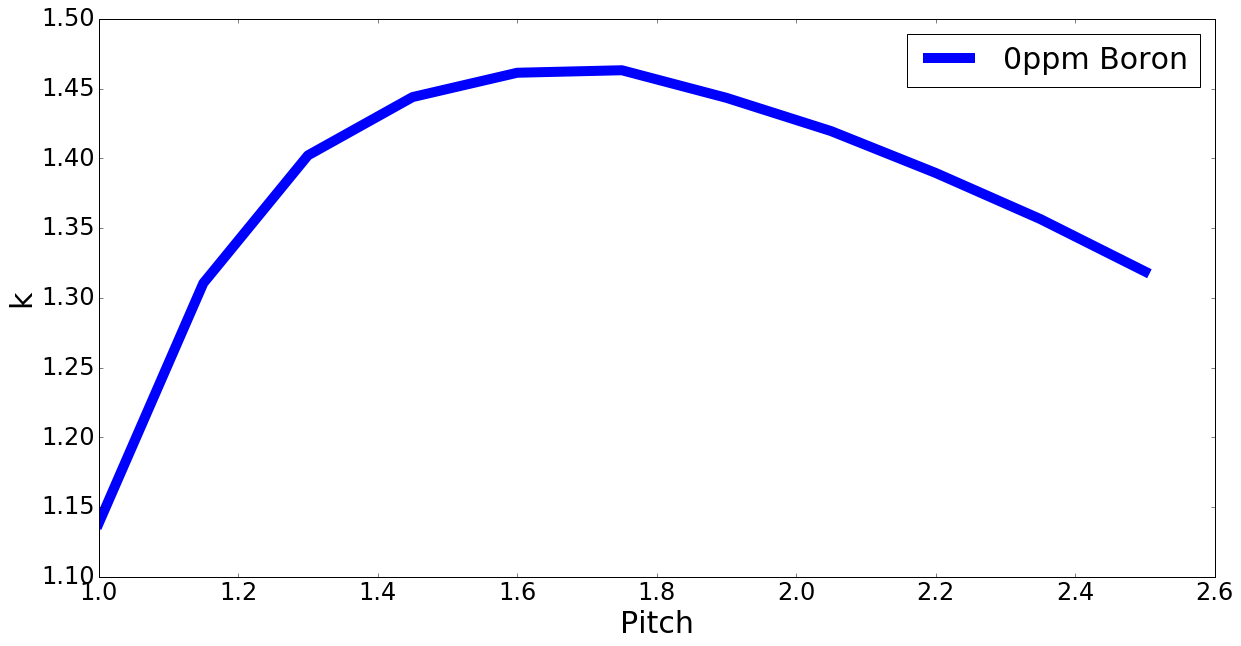

In [25]:
plt.figure(figsize=(20,10))
plt.plot(pitch,k[:,0], linewidth=10)
plt.legend(['0ppm Boron'], fontsize=30)
plt.xlabel('Pitch', fontsize=30)
plt.ylabel('k', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)